In [61]:
import shap
print(shap.__version__)

0.50.0


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from shap.datasets import iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [63]:
# Load  the data 
X, y=iris(display=True)

In [64]:
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [65]:
# It is a list, so we convert it to a Series for ease of use
y = pd.Series(y)
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Length: 150, dtype: object

In [66]:
# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [67]:
# Distribution of data 
print("Training data distribution:",X_train.shape[0])
print("Testing data distribution:",X_test.shape[0])

Training data distribution: 120
Testing data distribution: 30


In [68]:
# value counts for each data 
print("Training data class distribution:\n",pd.Series(y_train).value_counts(normalize=True)*100)
print("****"*20)
print("Testing data class distribution:\n",pd.Series(y_test).value_counts(normalize=True)*100)

Training data class distribution:
 versicolor    33.333333
virginica     33.333333
setosa        33.333333
Name: proportion, dtype: float64
********************************************************************************
Testing data class distribution:
 virginica     33.333333
versicolor    33.333333
setosa        33.333333
Name: proportion, dtype: float64


In [69]:
# Using label encoder to encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [70]:
# importing the model

model_rf = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

# Training the model
model_rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_t

In [71]:
# predicting the model for both train and test data
y_train_pred = model_rf.predict(X_train)
y_pred = model_rf.predict(X_test)

# Accuracy score for both train and test data
print("Training Accuracy:",accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:",accuracy_score(y_test, y_pred))

Training Accuracy: 0.9833333333333333
Testing Accuracy: 0.9666666666666667


In [72]:
# Expalaining the model predictions using SHAP
explainer = shap.TreeExplainer(
                                model=model_rf,
                                data=X_train,                # background dataset (positional arg)
                                model_output="probability"   # explain probabilities
)

In [73]:
# Base Value --  this is the mean model output over the training data (Average of each class probability)
explainer.expected_value

array([0.329     , 0.33866667, 0.33233333])

In [74]:
# These are not pb but logits as they are the mean of the raw model output for each class.
# How to convert them into probabilities?

logits = np.array([0.308  , 0.36025, 0.33175])
exp_vals = np.exp(logits)
probs = exp_vals / exp_vals.sum()
print(probs)


[0.32492077 0.34234923 0.33273   ]


In [75]:
# Calculating the mean values manually to cross verify [average predition probabilities for each class]
model_rf.predict_proba(X_train).mean(axis=0)

array([0.3325    , 0.33027778, 0.33722222])

In [76]:
# There is differece between the values calculated manually and by shap 
# bcz tree expliner by default samples 100 rows from data to estimate the expected value
# if we change the data explicitly and set limit on the training data we will get same values
explainer_half = shap.TreeExplainer(
                                model=model_rf,
                                data=X_train.iloc[:50:],                # background dataset (positional arg)
                                model_output="probability"   # explain probabilities
)

In [77]:
explainer_half.expected_value

array([0.38 , 0.308, 0.312])

In [78]:
model_rf.predict_proba(X_train.iloc[:50:]).mean(axis=0) 
# Hence verified

array([0.38 , 0.308, 0.312])

In [79]:
# Calculating SHAP values for test data
shap_values = explainer(X_test,y_test) # passing y_test is Optional
shap_values # this is a list of arrays, one for each class

.values =
array([[[-5.41666671e-02,  1.80833350e-02,  3.60833352e-02],
        [-6.66666694e-03, -3.57500010e-02,  4.24166679e-02],
        [-1.33166669e-01, -1.27916670e-01,  2.61083337e-01],
        [-1.35000002e-01, -1.98083336e-01,  3.33083340e-01]],

       [[-3.30000005e-02,  6.15833336e-02, -2.85833342e-02],
        [-1.93333336e-02,  7.24999979e-03,  1.20833339e-02],
        [-1.44833335e-01,  3.13583339e-01, -1.68750003e-01],
        [-1.31833335e-01,  2.73916671e-01, -1.42083337e-01]],

       [[-8.00000012e-03,  3.10000000e-02, -2.30000006e-02],
        [ 1.70500003e-01, -1.59000003e-01, -1.15000005e-02],
        [ 2.38000004e-01, -7.76666670e-02, -1.60333336e-01],
        [ 2.70500004e-01, -1.38000002e-01, -1.32500003e-01]],

       [[-5.51666673e-02,  4.00000202e-03,  5.11666703e-02],
        [-5.33333357e-03, -2.30000008e-02,  2.83333344e-02],
        [-1.34833336e-01, -1.85000004e-01,  3.19833338e-01],
        [-1.33666669e-01, -1.39666669e-01,  2.73333339e-01]],

      

In [80]:
# Calculating prediction and prediction_proba for 1st row of test data
print("Predicted class:",model_rf.predict(X_test.iloc[0:1,::]))
print("Predicted class probabilities:",model_rf.predict_proba(X_test.iloc[0:1,::])) # Gives prob for each class

Predicted class: [2]
Predicted class probabilities: [[0. 0. 1.]]


In [81]:
print(le.inverse_transform([1]))

['versicolor']


In [82]:
y_test[0] # actual class label for 1st row of test data

np.int64(2)

In [83]:
# Calculating SHAP values for 1st row of data for better understanding
shap_values = explainer(X_test.iloc[0:1,::]) 
shap_values 

.values =
array([[[-0.05416667,  0.01808334,  0.03608334],
        [-0.00666667, -0.03575   ,  0.04241667],
        [-0.13316667, -0.12791667,  0.26108334],
        [-0.135     , -0.19808334,  0.33308334]]])

.base_values =
array([[0.329     , 0.33866667, 0.33233333]])

.data =
array([[5.9, 3. , 5.1, 1.8]])

In [84]:
# What is .base value in shap_values object
print(shap_values.base_values)
print(explainer.expected_value)
# .base_values and explainer.expected_value are same {These are base values for each class}

[[0.329      0.33866667 0.33233333]]
[0.329      0.33866667 0.33233333]


In [85]:
# What is .data in shap_values object
print(shap_values.data)
print(X_test.iloc[0:1,::].values)
# .data is the input data for which we are calculating the shap values

[[5.9 3.  5.1 1.8]]
[[5.9 3.  5.1 1.8]]


In [86]:
shap_values.shape  # shape of SHAP values for class 0
# the shape is (number of input rows, number of input features, number of classes)

(1, 4, 3)

In [87]:
shap_values[0].shape  # shape of SHAP values for class 0

(4, 3)

In [88]:
shap_values[0]  #SHAP values for class 0
# here 1st row represents the shap value for sepal length,2nd rown represents the shap value for sepal width and so on.

.values =
array([[-0.05416667,  0.01808334,  0.03608334],
       [-0.00666667, -0.03575   ,  0.04241667],
       [-0.13316667, -0.12791667,  0.26108334],
       [-0.135     , -0.19808334,  0.33308334]])

.base_values =
array([0.329     , 0.33866667, 0.33233333])

.data =
array([5.9, 3. , 5.1, 1.8])

In [89]:
shap_values[0,:,0]  # last 0 represents class 0

.values =
array([-0.05416667, -0.00666667, -0.13316667, -0.135     ])

.base_values =
np.float64(0.3289999999999999)

.data =
array([5.9, 3. , 5.1, 1.8])

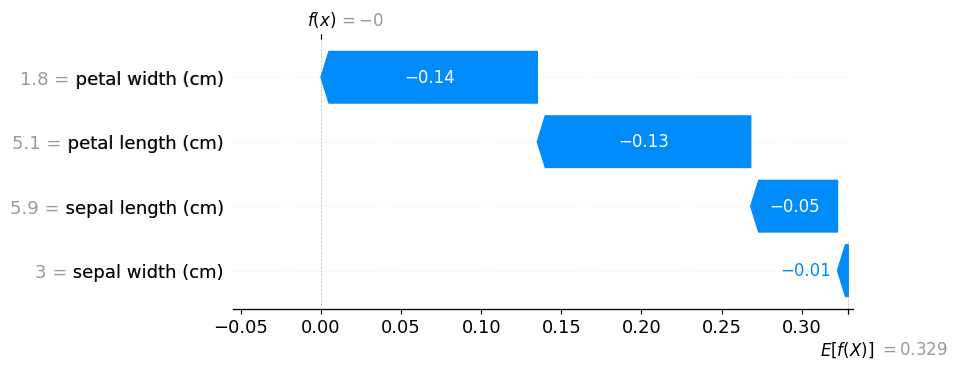

In [90]:
# projecting the SHAP values to get the model output for each class
shap.waterfall_plot(shap_values[0,:,0])
plt.show()

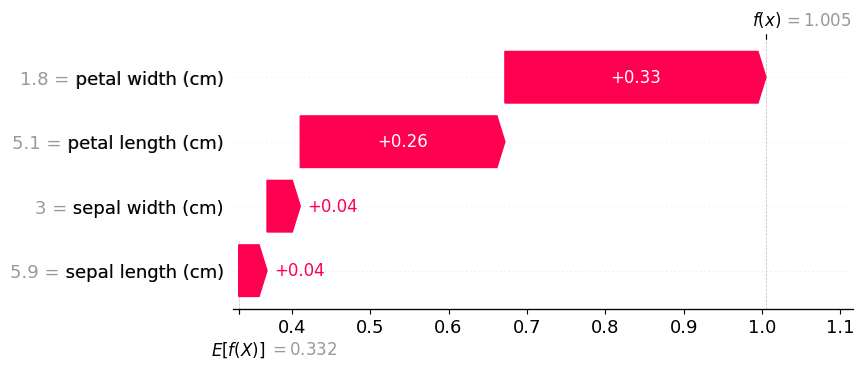

In [96]:
shap.waterfall_plot(shap_values[0,:,2])
plt.show()

In [102]:
round(shap_values[0,:,2].values.sum() + shap_values[0,:,2].base_values)

1

In [104]:
le.inverse_transform([1])

array(['versicolor'], dtype=object)